In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

2.0.3
3.1


In [3]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time



/Users/ninakerff/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes

problem_formulation = 3 # 0, 1, 2, 3, 4, 5
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation)

In [5]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [6]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [7]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('A.1 Total Costs', variable_name=('A.1_Expected Annual Damage', 'A.1_Dike Investment Costs'), function=<function sum_over at 0x1466093a0>)
ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths',), function=<function sum_over at 0x1466093a0>)
ScalarOutcome('A.2 Total Costs', variable_name=('A.2_Expected Annual Damage', 'A.2_Dike Investment Costs'), function=<function sum_over at 0x1466093a0>)
ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths',), function=<function sum_over at 0x1466093a0>)
ScalarOutcome('A.3 Total Costs', variable_name=('A.3_Expected Annual Damage', 'A.3_Dike Investment Costs'), function=<function sum_over at 0x1466093a0>)
ScalarOutcome('A.3_Expected Number of Deaths', variable_name=('A.3_Expected Number of Deaths',), function=<function sum_over at 0x1466093a0>)
ScalarOutcome('A.4 Total Costs', variable_name=('A.4_Expected Annual Damage', 'A.4_Dike Investment Costs'), functio

## Defining own policies

In [10]:
# defining specific policies
# for example, policy 1 is about extra protection in upper boundary
# policy 2 is about extra protection in lower boundary
# policy 3 is extra protection in random locations


def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [

    Policy("Do Nothing", **get_do_nothing_dict()),

    # Policy("Full NOT RfR Strategy", **dict(
    #     get_do_nothing_dict(),
    #     **{f"{i}_RfR 0": 0 for i in range(4)}
    # )),

    # Policy("Full RfR Strategy", **dict(
    #     get_do_nothing_dict(),
    #     **{f"{i}_RfR 0": 1 for i in range(4)}
    # )),

    # Policy("No Warning", **dict(
    #     get_do_nothing_dict(),
    #     **{"EWS_DaysToThreat": 0}
    # )),

    # Policy("Eaarly Warning", **dict(
    #     get_do_nothing_dict(),
    #     **{"EWS_DaysToThreat": 4}
    # )),




    # Policy(
    #     "policy 1",
    #     **dict(
    #         get_do_nothing_dict(),
    #         **{"0_RfR 0": 1, "0_RfR 1": 1, "0_RfR 2": 1, "A.1_DikeIncrease 0": 5}
    #     )
    #  ),
    # Policy(
    #     "policy 2",
    #     **dict(
    #         get_do_nothing_dict(),
    #         **{"4_RfR 0": 1, "4_RfR 1": 1, "4_RfR 2": 1, "A.5_DikeIncrease 0": 5}
    #     )
    # ),
    # Policy(
    #     "policy 3",
    #     **dict(
    #         get_do_nothing_dict(),
    #         **{"1_RfR 0": 1, "2_RfR 1": 1, "3_RfR 2": 1, "A.3_DikeIncrease 0": 5}
    #     )
    # ),
]

In [11]:
# pass the policies list to EMA workbench experiment runs
n_scenarios = 100
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

/Users/ninakerff/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/ninakerff/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/ninakerff/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/ninakerff/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEv

In [12]:
experiments, outcomes = results


In [13]:
# only works because we have scalar outcomes
outcomes = outcomes.copy()
outcomes['policy'] = experiments['policy'].values
df_outcomes = pd.DataFrame(outcomes)
df_outcomes

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,policy
0,0.000000e+00,0.000000,1.407993e+07,0.012266,2.222025e+09,3.291788,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,Do Nothing
1,9.863601e+07,0.068889,5.923078e+07,0.054947,2.039918e+09,3.335026,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,Do Nothing
2,2.529283e+09,1.826200,0.000000e+00,0.000000,1.342321e+08,0.247059,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,Do Nothing
3,0.000000e+00,0.000000,1.115134e+08,0.142207,1.239564e+09,2.876824,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,Do Nothing
4,2.814121e+09,1.827591,8.602297e+06,0.007787,0.000000e+00,0.000000,1.273590e+07,0.005728,0.000000e+00,0.000000,0.0,0.0,Do Nothing
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.541079e+06,0.003598,3.038206e+07,0.040862,3.088378e+07,0.078086,1.064697e+08,0.064651,0.000000e+00,0.000000,0.0,0.0,Do Nothing
96,2.200480e+09,1.828128,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.0,Do Nothing
97,2.660816e+09,1.821668,5.258056e+07,0.050167,0.000000e+00,0.000000,0.000000e+00,0.000000,1.835015e+07,0.017118,0.0,0.0,Do Nothing
98,1.567985e+08,0.100043,6.345390e+08,0.500876,2.416921e+07,0.037674,5.682999e+07,0.020891,0.000000e+00,0.000000,0.0,0.0,Do Nothing


In [14]:
# Define segment numbers
segments = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']

# Extract cost columns and death columns
cost_cols = [f"{seg} Total Costs" for seg in segments]
death_cols = [f"{seg}_Expected Number of Deaths" for seg in segments]

# Melt costs
costs_long = df_outcomes.melt(id_vars='policy', value_vars=cost_cols,
                             var_name='Segment', value_name='Total Costs')
costs_long['Segment'] = costs_long['Segment'].str.extract(r'(A\.\d)')  # Extract segment label
costs_long['Metric'] = 'Total Costs'

# Melt deaths
deaths_long = df_outcomes.melt(id_vars='policy', value_vars=death_cols,
                              var_name='Segment', value_name='Expected Deaths')
deaths_long['Segment'] = deaths_long['Segment'].str.extract(r'(A\.\d)')
deaths_long['Metric'] = 'Expected Deaths'

# Rename for consistency in the 'value' column
costs_long.rename(columns={'Total Costs': 'Value'}, inplace=True)
deaths_long.rename(columns={'Expected Deaths': 'Value'}, inplace=True)

# Combine both metrics into one DataFrame
df_long = pd.concat([costs_long, deaths_long], ignore_index=True)

## Plots

/Users/ninakerff/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1400x700 with 0 Axes>

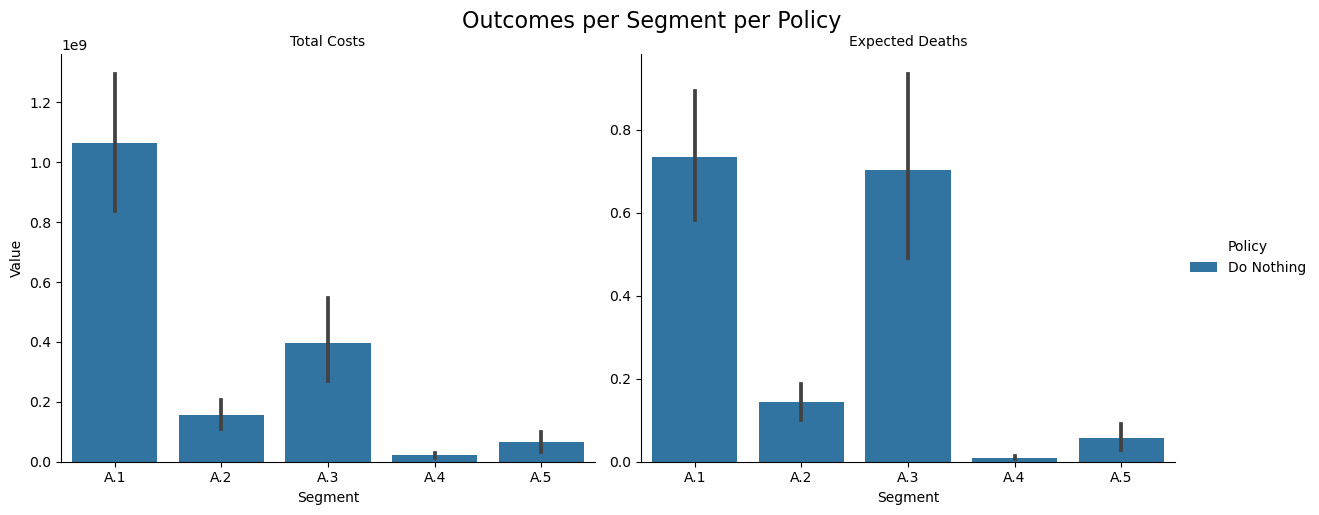

In [15]:
plt.figure(figsize=(14, 7))

# Create a barplot with facet for each metric
g = sns.catplot(
    data=df_long,
    x='Segment',
    y='Value',
    hue='policy',
    col='Metric',
    kind='bar',
    height=5,
    aspect=1.2,
    #ci='sd',  # Show standard deviation error bars if multiple runs per policy
    sharey=False
)

g.set_axis_labels("Segment", "Value")
g.set_titles("{col_name}")
g._legend.set_title("Policy")
plt.suptitle("Outcomes per Segment per Policy", y=1.02, fontsize=16)
plt.show()

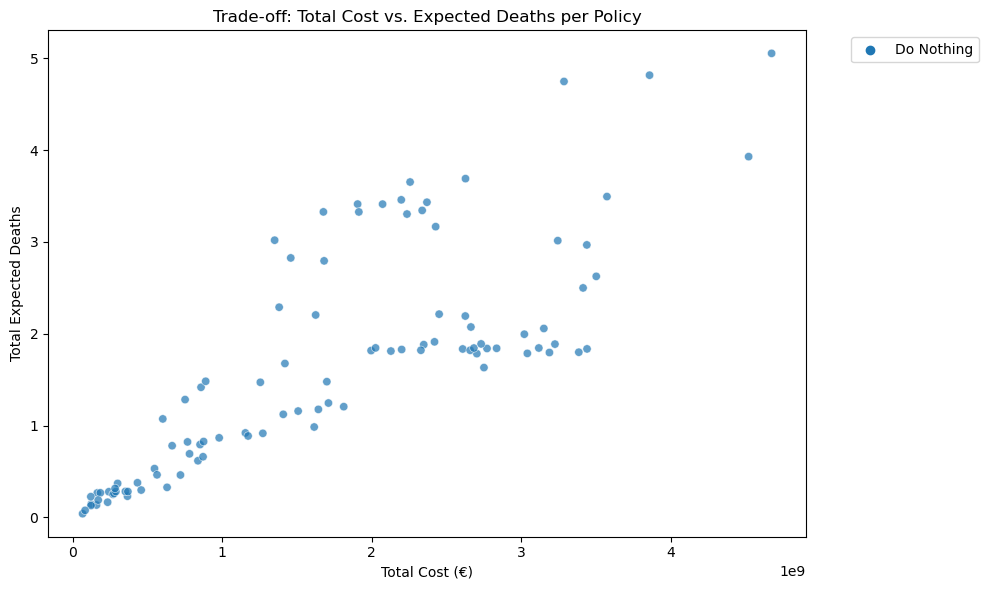

In [17]:
# Segment-specific columns
cost_columns = [col for col in df_outcomes.columns if "Total Costs" in col and "RfR" not in col]
death_columns = [col for col in df_outcomes.columns if "Expected Number of Deaths" in col and "Total" not in col and "Evacuation" not in col]

df_outcomes['Total Cost Sum'] = df_outcomes[cost_columns].sum(axis=1)
df_outcomes['Total Deaths Sum'] = df_outcomes[death_columns].sum(axis=1)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_outcomes,
    x='Total Cost Sum',
    y='Total Deaths Sum',
    hue='policy',
    alpha=0.7
)
plt.title("Trade-off: Total Cost vs. Expected Deaths per Policy")
plt.xlabel("Total Cost (€)")
plt.ylabel("Total Expected Deaths")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()